<a href="https://colab.research.google.com/github/sanazy/Plate-Detection-Project/blob/master/04_traffic_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
# Get ready for Inference

In [ ]:
TEST_PATH = '/content/drive/My Drive/Traffic/test/'
EFF_PATH = '/content/drive/My\ Drive/Traffic/EfficientDet/'
%cd {EFF_PATH}

/content/drive/My Drive/Traffic/EfficientDet


In [ ]:
!pip install -r {EFF_PATH}/requirements.txt -q

***
# Inference

In [ ]:
import cv2
import json
import numpy as np
import os
import time
import glob
import random
import ntpath
from scipy import stats

import matplotlib.pyplot as plt
from model import efficientdet
from utils import preprocess_image, postprocess_boxes
from utils.nms import non_max_suppression
from utils.draw_boxes import draw_boxes
from google.colab.patches import cv2_imshow

In [ ]:
def inference():

  phi = 0
  weighted_bifpn = False
  model_path = 'checkpoints/2020-06-21-07:14:54-10-5-900/csv_10_0.1047_0.1514.h5'
  image_sizes = (256, 640, 768, 896, 1024, 1280, 1408)
  image_size = image_sizes[phi]
  classes = {0: 'light', 1: 'heavy', 2: 'unkonwn'}
  num_classes = 3
  score_threshold = 0.5
  overlapThresh = 0.7

  
  colors = [np.random.randint(0, 256, 3).tolist() for _ in range(num_classes)]
  _, model = efficientdet(phi=phi,
                          weighted_bifpn=weighted_bifpn,
                          num_classes=num_classes,
                          score_threshold=score_threshold)
  model.load_weights(model_path, by_name=True)

  times, image_names, images = [], [], []
  for image_name in glob.glob(TEST_PATH + '*.jpg'):
    image = cv2.imread(image_name)
    src_image = image.copy()
    # BGR -> RGB
    image = image[:, :, ::-1]
    h, w = image.shape[:2]

    image, scale = preprocess_image(image, image_size=image_size)
    # run network
    start = time.time()
    boxes, scores, labels = model.predict_on_batch([np.expand_dims(image, axis=0)])
    boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
    times.append(round(time.time() - start, 3))
    boxes = postprocess_boxes(boxes=boxes, scale=scale, height=h, width=w)
    
    # Remove extra overlapped boxes 
    boxes = non_max_suppression(boxes, overlapThresh)

    # select indices which have a score above the threshold
    indices = np.where(scores[:] > score_threshold)[0]

    # select those detections
    boxes = boxes[indices]
    labels = labels[indices]

    draw_boxes(src_image, boxes, scores, labels, colors, classes)
    
    # Append image to images array for later displaying
    images.append(src_image)

    # Append tail of image name for later saving
    head, tail = ntpath.split(image_name)
    image_names.append(tail)

  return times, image_names, images

In [ ]:
def show_images(images):
  rows, columns = 10, 2
  width, height = 15, 60
  fig = plt.figure(figsize=(width, height))
  ax = []

  for i, image in enumerate(images):
    image = image[:, :, ::-1]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(i+1)
    plt.axis('off')
    plt.imshow(image)
  
  plt.show()

***


In [ ]:
times, image_names, images = inference()

In [ ]:
del times[0] # Remove first element because takes time for initialization
print(times)
stats.describe(times)

[0.101, 0.101, 0.1, 0.101, 0.1, 0.099, 0.097, 0.103, 0.101, 0.1, 0.099, 0.098, 0.099, 0.097, 0.1, 0.098, 0.098, 0.097, 0.096, 0.097, 0.1, 0.099, 0.098, 0.097, 0.096, 0.095, 0.11, 0.099, 0.1, 0.102, 0.101, 0.099, 0.099, 0.106, 0.095, 0.097, 0.101, 0.099, 0.116, 0.103, 0.097, 0.098, 0.104, 0.098, 0.1, 0.097, 0.102, 0.097, 0.103, 0.096, 0.101, 0.102, 0.101, 0.098, 0.102, 0.099, 0.098, 0.099, 0.103, 0.103, 0.099, 0.101, 0.102, 0.101, 0.096, 0.1, 0.098, 0.113, 0.101, 0.096, 0.098, 0.098, 0.099, 0.104, 0.097, 0.098, 0.097, 0.097, 0.098, 0.101, 0.097, 0.104, 0.098, 0.098, 0.1, 0.098, 0.134, 0.096, 0.099, 0.106, 0.101, 0.098, 0.101, 0.099, 0.105, 0.097, 0.098, 0.098, 0.105, 0.097, 0.113, 0.108, 0.098, 0.1, 0.099, 0.098, 0.1, 0.098, 0.097, 0.098, 0.096, 0.106, 0.097, 0.1, 0.097, 0.099, 0.099, 0.106, 0.099, 0.099, 0.101, 0.098, 0.109, 0.1, 0.1, 0.098, 0.103, 0.098, 0.101, 0.097, 0.109, 0.107, 0.1, 0.099, 0.099, 0.108, 0.102, 0.11, 0.1, 0.101, 0.1, 0.124, 0.098, 0.097, 0.101, 0.099, 0.101, 0.107,

DescribeResult(nobs=282, minmax=(0.095, 0.134), mean=0.10072340425531913, variance=2.112606950859392e-05, skewness=3.2509887583841874, kurtosis=16.6941877665852)

{'boxes': [<matplotlib.lines.Line2D at 0x7fd90dbbc668>],
 'caps': [<matplotlib.lines.Line2D at 0x7fd90dbc80b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fd90dbc8b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fd90dbc87b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fd90dbbc978>,
  <matplotlib.lines.Line2D at 0x7fd90dbbccf8>]}

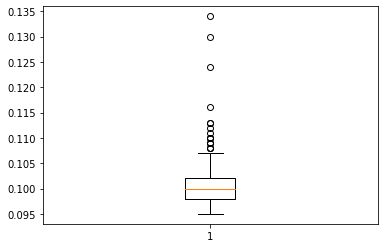

In [ ]:
# Distribution of model training elapsed time 
plt.boxplot(times)

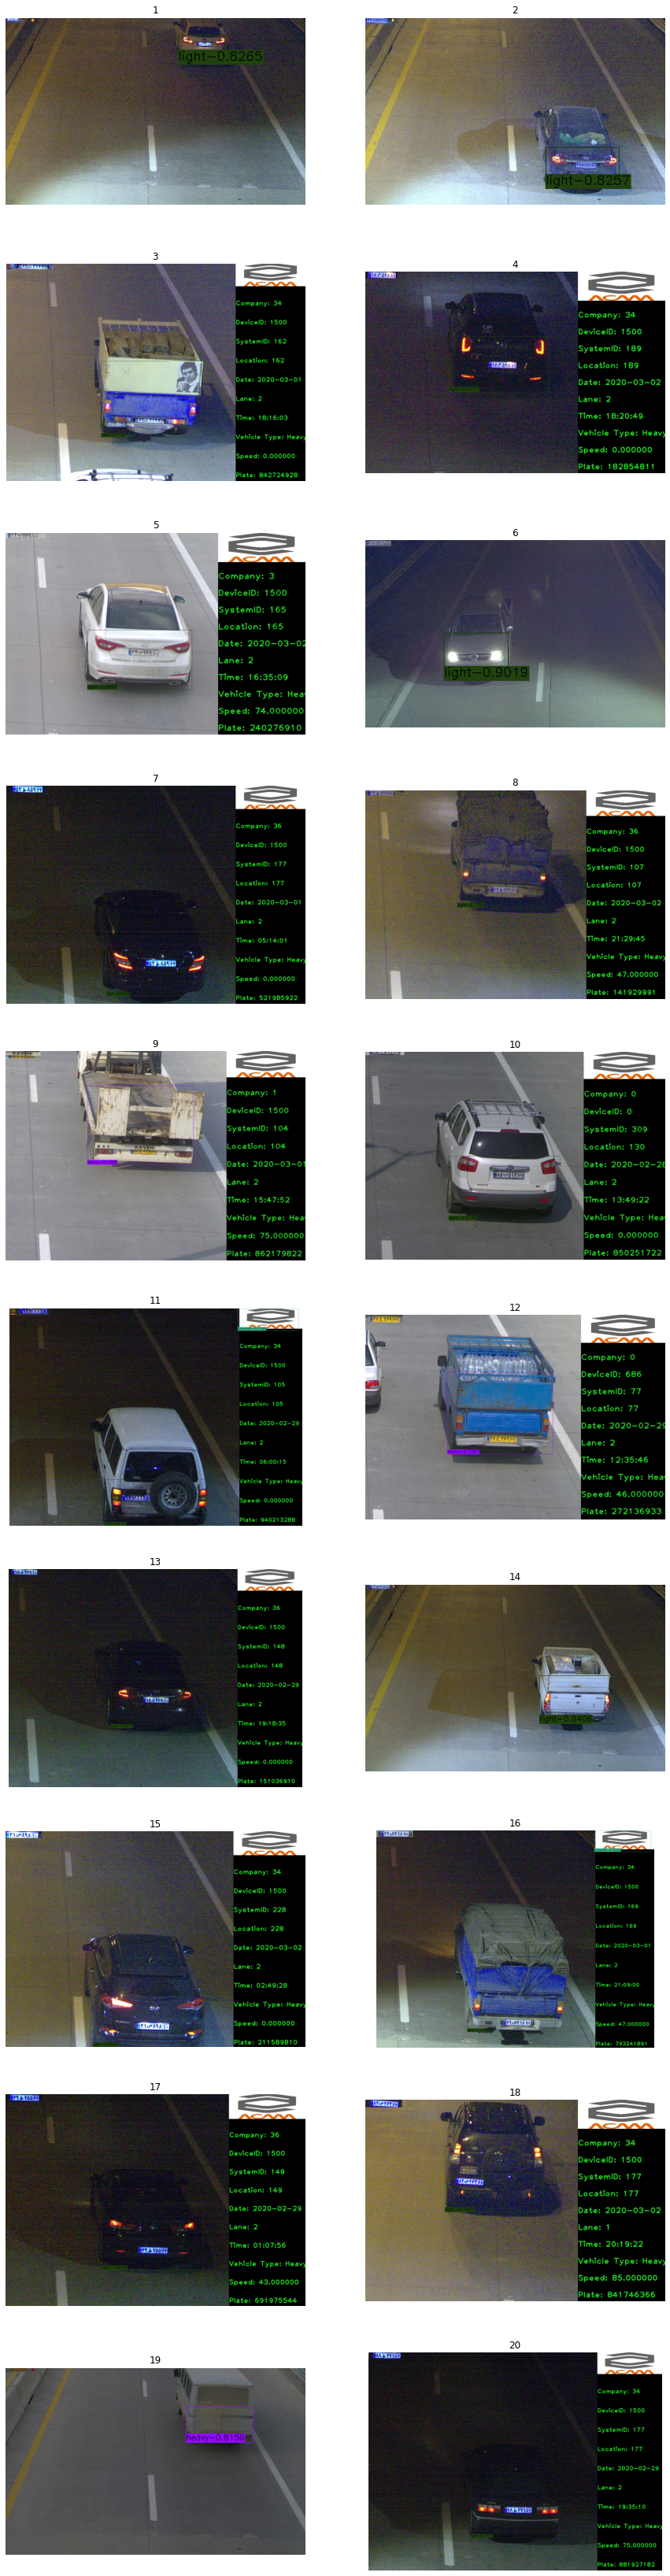

In [ ]:
# Show some random images
num_to_select = 20
random_images = random.sample(images, num_to_select)
show_images(random_images)

In [ ]:
# Save test images with their boundries
path_to_write = '/content/drive/My Drive/Traffic/test_box/'

for i,image in enumerate(images):
  image_name = image_names[i]
  cv2.imwrite(path_to_write + image_name, image)